# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
save_path='/content/drive/MyDrive/food_seg_model/unet.keras'

# Needed Libraries

In [3]:
!pip install tifffile
import tifffile as tiff
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.4 MB/s eta 0:00:00


In [13]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.9 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Input,Conv2DTranspose,Dropout,BatchNormalization,Activation,concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import shutil
import rasterio
from sklearn.model_selection import train_test_split
import pywt
from skimage.filters.rank import entropy
from skimage.morphology import disk
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.models as models
import pywt
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2, fftshift
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


# Explore the Data

In [5]:
img_size=256

In [6]:
img_dir = '/content/drive/MyDrive/filtered/images'
mask_dir = '/content/drive/MyDrive/filtered/masks'

In [7]:
print(len(os.listdir(img_dir)))
print(len(os.listdir(mask_dir)))

306
306


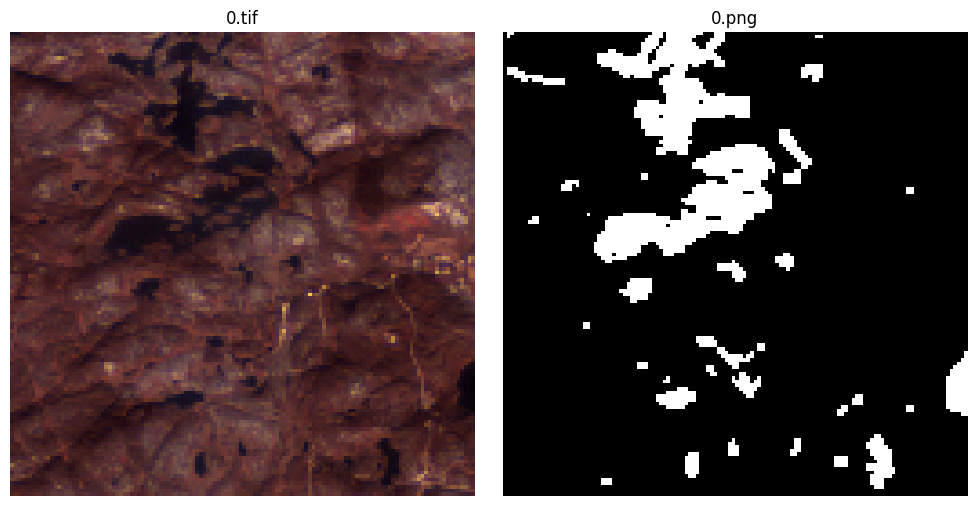

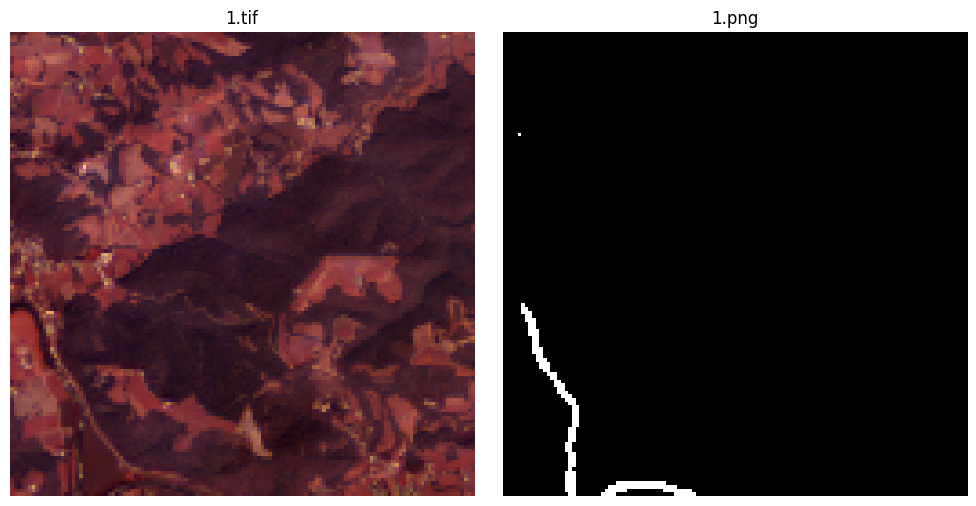

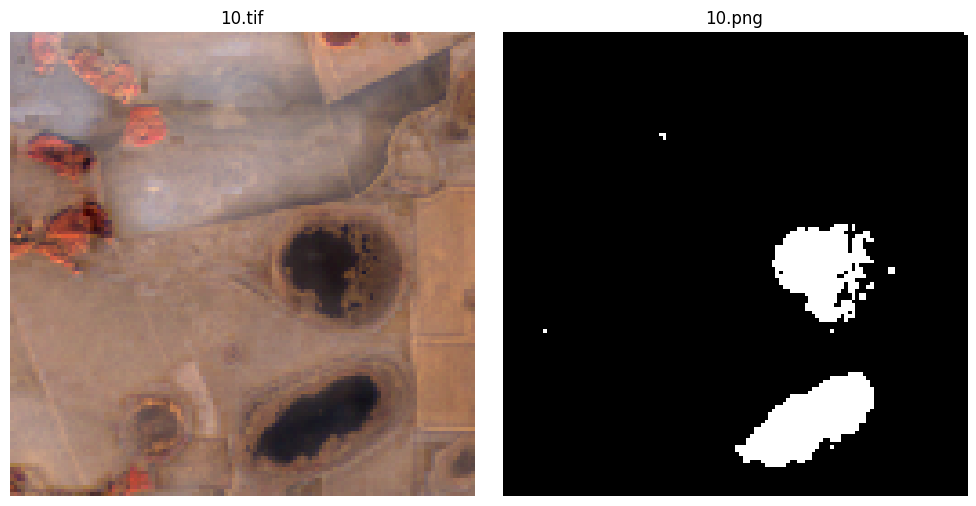

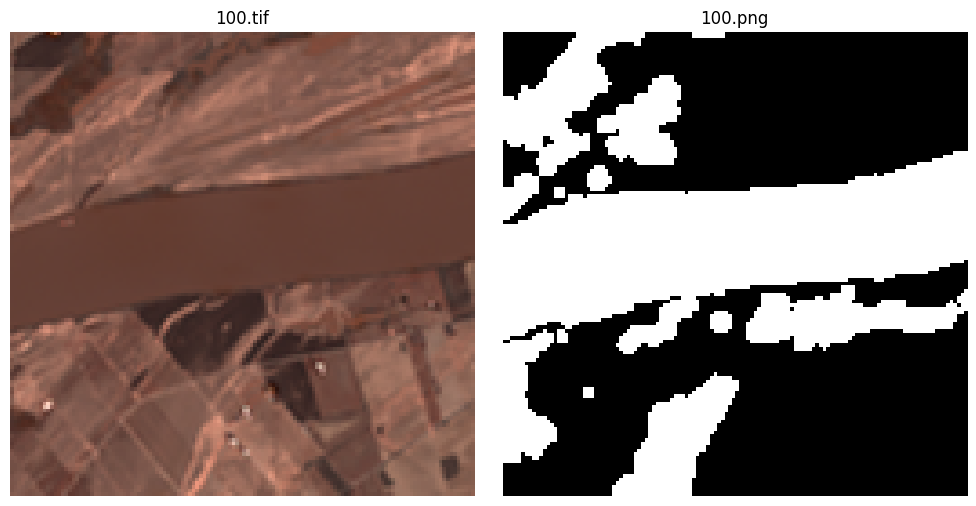

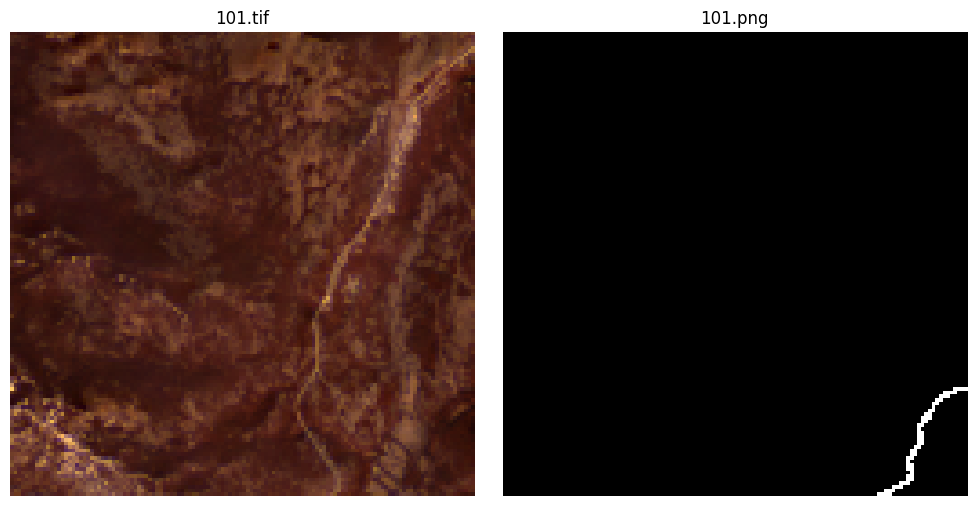

In [8]:
def show_sample(image_path, mask_path):
    # Load the .tif image (satellite)
    image = tiff.imread(image_path)

    # If image is (12, H, W), convert to (H, W, 12)
    if image.ndim == 3 and image.shape[0] == 12:
        image = np.transpose(image, (1, 2, 0))

    # Pick RGB bands (commonly [2,1,0] = R,G,B)
    rgb_image = image[:, :, [2, 1, 0]]

    # Normalize for visualization
    rgb_image = rgb_image.astype(np.float32)
    rgb_image -= rgb_image.min()
    rgb_image /= rgb_image.max()

    # Load the mask (assumed .png)
    mask = Image.open(mask_path)
    mask = np.array(mask)

    # Plot both
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title(image_path.split('/')[-1])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_path.split('/')[-1])
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Pick any 3 samples
image_files = sorted(os.listdir(img_dir))[:5]
mask_files = sorted(os.listdir(mask_dir))[:5]

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(img_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)
    show_sample(image_path, mask_path)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


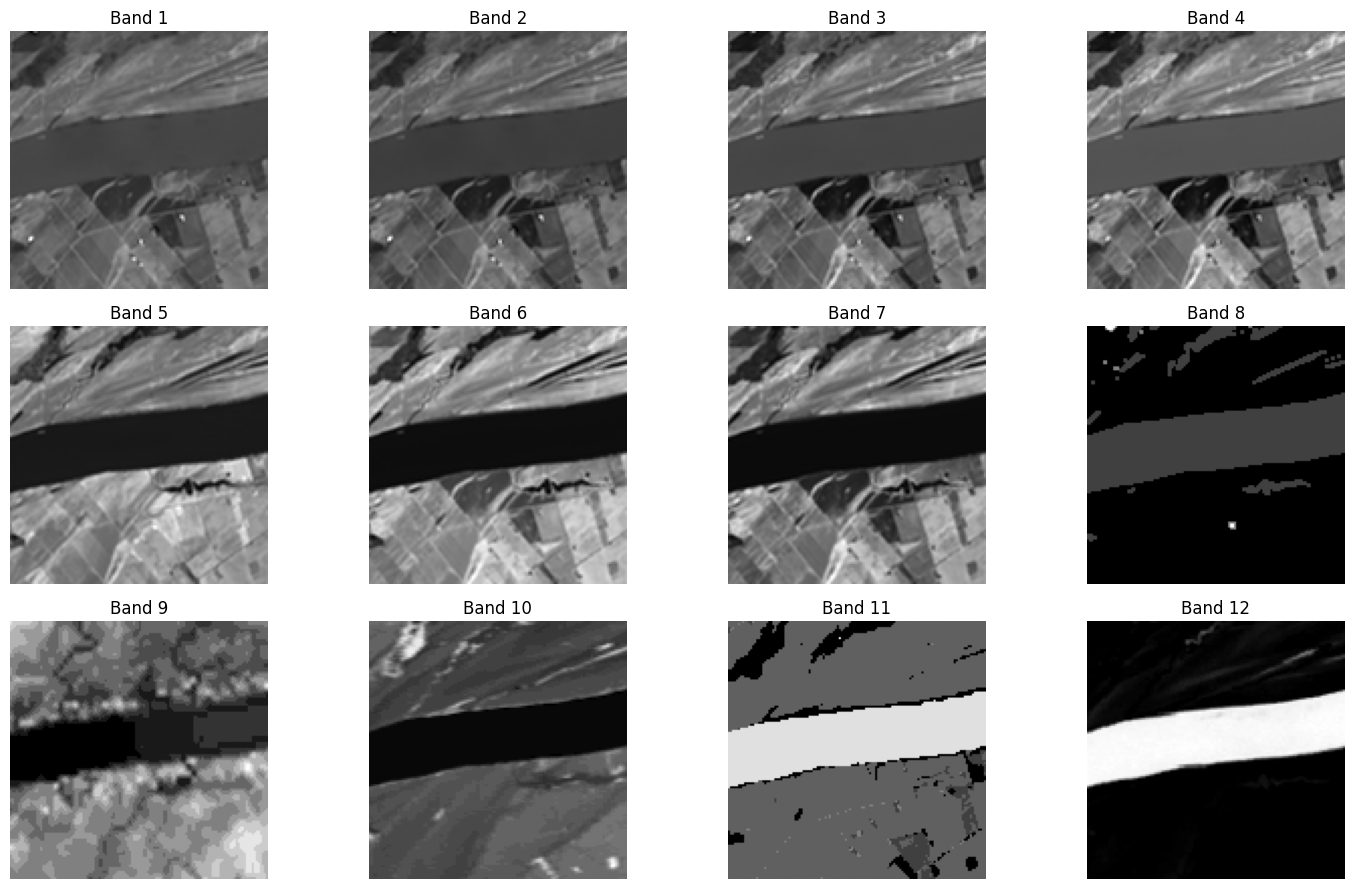

In [9]:
image_path = '/content/drive/MyDrive/filtered/images/100.tif'
with rasterio.open(image_path) as src:
    img = src.read()  # shape: (bands, height, width)

# Get number of bands
num_bands = img.shape[0]

# Plot each band
cols = 4
rows = (num_bands + cols - 1) // cols  # auto-calculate rows
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for i in range(rows * cols):
    ax = axs[i // cols, i % cols]
    if i < num_bands:
        ax.imshow(img[i], cmap='gray')
        ax.set_title(f'Band {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


File: /content/drive/MyDrive/filtered/images/100.tif
Number of bands: 12
Shape: 128 x 128
CRS: None
Resolution: (1.0, 1.0)
Descriptions: (None, None, None, None, None, None, None, None, None, None, None, None)
Dtype: ('int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16')
Indexes: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
Normalized data shape: (12, 128, 128)


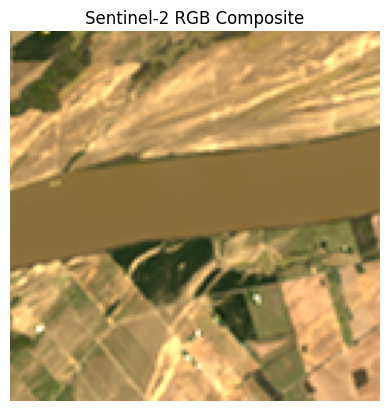

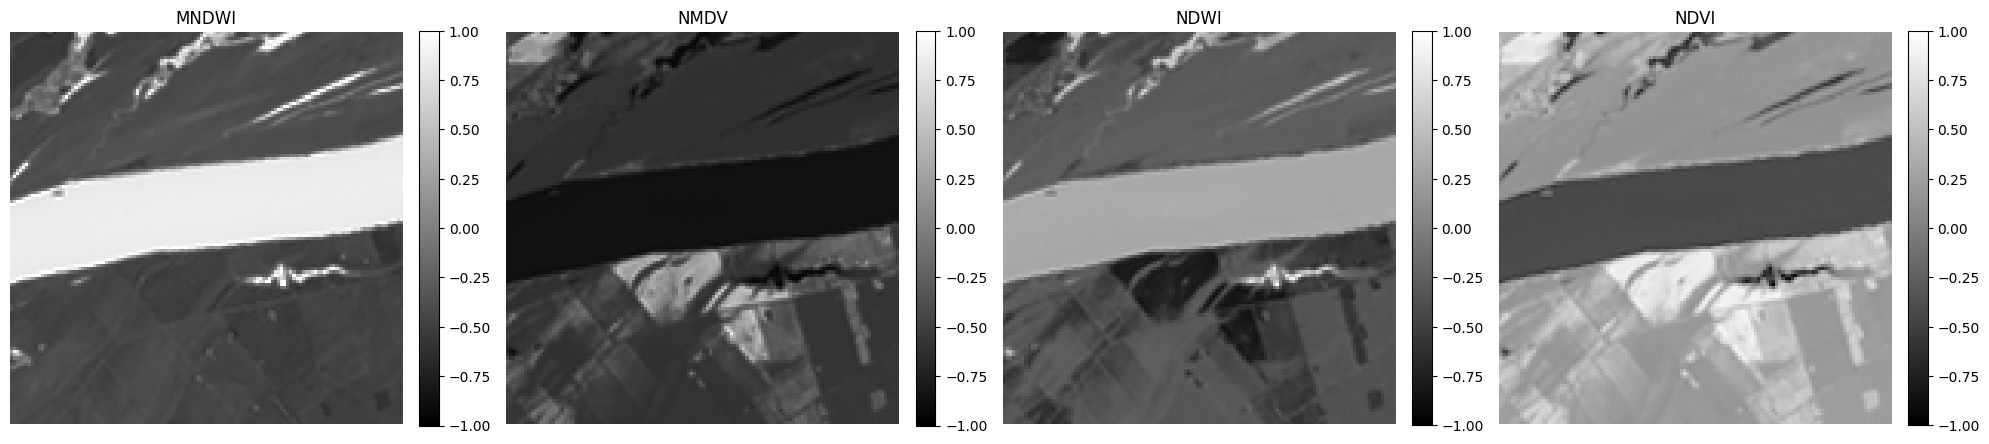

In [10]:
tif_path = "/content/drive/MyDrive/filtered/images/100.tif"

with rasterio.open(tif_path) as src:
    image = src.read()
    print(f"File: {tif_path}")
    print(f"Number of bands: {src.count}")
    print(f"Shape: {src.height} x {src.width}")
    print(f"CRS: {src.crs}")
    print("Resolution:", src.res)
    print(f"Descriptions: {src.descriptions}")
    print(f"Dtype: {src.dtypes}")
    print(f"Indexes: {src.indexes}")

normalized = np.empty_like(image, dtype=np.float32)
unnormalized = np.empty_like(image, dtype=np.float32)

for i in range(image.shape[0]):
    band = image[i]
    if i == 0:
        normalized[i] = band / 10000.0
    elif i in [1,2,3]:
        normalized[i] = band / 255.0
    elif i in [4,5,6]:
        normalized[i] = band / 1000.0
        unnormalized[i]=band/255.0
    elif i == 7:
        normalized[i] = band.astype(np.float16)
    elif i in [8, 9]:
        normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
    elif i == 10:
        normalized[i] = band.astype(np.float16)
    elif i == 11:
        normalized[i] = band / 100.0

print("Normalized data shape:", normalized.shape)

rgb = np.stack([
    normalized[3],
    normalized[2],
    normalized[1],
], axis=-1)
mndwi = (normalized[2] - unnormalized[5]) / (normalized[2] + unnormalized[5] + 1e-6)
ndwi = (normalized[2] - unnormalized[4]) / (normalized[2] + unnormalized[4] + 1e-6)
ndvi = (unnormalized[4] - normalized[3]) / (unnormalized[4] + normalized[3] + 1e-6)
ndti  = (normalized[5] - normalized[6]) / (normalized[5] + normalized[6] + 1e-6)
nmdv = (normalized[4] - (normalized[3] + normalized[1])) / (normalized[4] + normalized[3] + normalized[1] + 1e-6)
nmdv = np.clip(nmdv, -1, 1)
mndwi = np.clip(mndwi, -1, 1)
ndwi = np.clip(ndwi, -1, 1)
ndvi = np.clip(ndvi, -1, 1)
spect = np.stack([mndwi, nmdv, ndwi, ndvi, ndwi], axis=-1)
rgb /= np.percentile(rgb, 98)
rgb = np.clip(rgb, 0, 1)
plt.imshow(rgb)
plt.title("Sentinel-2 RGB Composite")
plt.axis("off")
plt.show()

titles = ['MNDWI', 'NMDV','NDWI', 'NDVI', 'NDWI']
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

for i, ax in enumerate(axs):
    im = ax.imshow(spect[..., i], cmap='gray', vmin=-1, vmax=1)
    ax.set_title(titles[i])
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

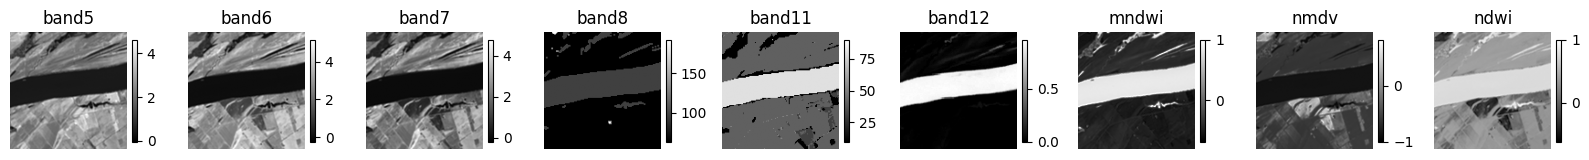

In [17]:
def stack_selected_bands(tif_path):
    with rasterio.open(tif_path) as src:
        image = src.read().astype(np.float32)  # shape: (bands, H, W)

    normalized = np.empty_like(image, dtype=np.float32)
    unnormalized = np.empty_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
      band = image[i]
      if i == 0:
          normalized[i] = band / 10000.0
      elif i in [1,2,3]:
          normalized[i] = band / 255.0
      elif i in [4,5,6]:
          normalized[i] = band / 1000.0
          unnormalized[i]=band/255.0
      elif i == 7:
          normalized[i] = band.astype(np.float16)
      elif i in [8, 9]:
          normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
      elif i == 10:
          normalized[i] = band.astype(np.float16)
      elif i == 11:
          normalized[i] = band / 100.0

    mndwi = (normalized[2] - unnormalized[5]) / (normalized[2] + unnormalized[5] + 1e-6)
    nmdv = (normalized[4] - (normalized[3] + normalized[1])) / (normalized[4] + normalized[3] + normalized[1] + 1e-6)
    ndwi = (normalized[2] - normalized[4]) / (normalized[2] + normalized[4] + 1e-6)
    nmdv = np.clip(nmdv, -1, 1)
    mndwi = np.clip(mndwi, -1, 1)
    ndwi = np.clip(ndwi, -1, 1)

    spect = np.stack([normalized[4],normalized[5],normalized[6],normalized[7],normalized[10],normalized[11],mndwi, nmdv, ndwi], axis=-1)

    return spect


def visualize_water_indices(indices):
    names = ['band5', 'band6', 'band7', 'band8', 'band11','band12', 'mndwi', 'nmdv', 'ndwi']
    plt.figure(figsize=(16, 4))

    for i in range(indices.shape[-1]):
        plt.subplot(1, 9, i + 1)
        plt.imshow(indices[:, :, i], cmap='gray')
        plt.colorbar(fraction=0.04, pad=0.04)
        plt.title(names[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

image = '/content/drive/MyDrive/filtered/images/100.tif'

# Compute indices
indices = stack_selected_bands(image)

# Visualize them
visualize_water_indices(indices)

# Data Generator

In [18]:
image_paths = [os.path.join(img_dir, file) for file in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, file) for file in os.listdir(mask_dir)]

train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(
    val_img_paths, val_mask_paths, test_size=0.5, random_state=42
)

In [22]:
def compute_advanced_features(image):
    features = []
    for i in range(image.shape[-1]):
        band = image[..., i].astype(np.float32)  # Ensure float32 for OpenCV

        # Gradient (Sobel)
        grad_x = cv2.Sobel(band, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(band, cv2.CV_32F, 0, 1, ksize=3)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Laplacian
        lap = cv2.Laplacian(band, cv2.CV_32F, ksize=3)

        # Wavelet (Haar)
        coeffs = pywt.dwt2(band, 'haar')
        cA, (cH, cV, cD) = coeffs
        cH_resized = cv2.resize(cH, (band.shape[1], band.shape[0]), interpolation=cv2.INTER_LINEAR)
        cV_resized = cv2.resize(cV, (band.shape[1], band.shape[0]), interpolation=cv2.INTER_LINEAR)
        cD_resized = cv2.resize(cD, (band.shape[1], band.shape[0]), interpolation=cv2.INTER_LINEAR)

        # Entropy
        band_uint8 = cv2.normalize(band, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        entropy_img = entropy(band_uint8, disk(3)).astype(np.float32)

        features.extend([magnitude, lap, cH_resized, cV_resized, cD_resized, entropy_img])

    return np.stack(features, axis=-1).astype(np.float32)  # (H, W, bands * 6)


def stack_selected_bands(tif_path):
    with rasterio.open(tif_path) as src:
        image = src.read().astype(np.float32)  # shape: (bands, H, W)

    normalized = np.empty_like(image, dtype=np.float32)
    unnormalized = np.zeros_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
        band = image[i]
        if i == 0:
            normalized[i] = band / 10000.0
        elif i in [1, 2, 3]:
            normalized[i] = band / 255.0
        elif i in [4, 5, 6]:
            normalized[i] = band / 1000.0
            unnormalized[i] = band / 255.0
        elif i == 7 or i == 10:
            normalized[i] = band  # Already float32
        elif i in [8, 9]:
            norm_range = band.max() - band.min() + 1e-5
            normalized[i] = (band - band.min()) / norm_range
        elif i == 11:
            normalized[i] = band / 100.0

    # Derived indices
    mndwi = (normalized[2] - unnormalized[5]) / (normalized[2] + unnormalized[5] + 1e-6)
    nmdv = (normalized[4] - (normalized[3] + normalized[1])) / (normalized[4] + normalized[3] + normalized[1] + 1e-6)
    ndwi = (normalized[2] - normalized[4]) / (normalized[2] + normalized[4] + 1e-6)
    mndwi = np.clip(mndwi, -1, 1)
    nmdv = np.clip(nmdv, -1, 1)
    ndwi = np.clip(ndwi, -1, 1)

    # Stack selected + derived features
    stacked = np.stack([
        normalized[4], normalized[5], normalized[6], normalized[7],
        normalized[10], normalized[11], mndwi, nmdv,ndwi
    ], axis=-1)

    # Advanced features
    advanced = compute_advanced_features(stacked)  # (H, W, 48)

    # Final: 8 base + 17 advanced = 26
    full = np.concatenate([stacked, advanced[..., :17]], axis=-1).astype(np.float32)  # (H, W, 26)

    return full

class SentinelSegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_paths[i] for i in batch_indices]
        batch_masks = [self.mask_paths[i] for i in batch_indices]

        X = [stack_selected_bands(img_path).astype(np.float32) for img_path in batch_images]
        y = [self.load_mask(mask_path).astype(np.float32) for mask_path in batch_masks]

        X = np.stack(X, axis=0).astype(np.float32)  # (B, H, W, 26)
        y = np.stack(y, axis=0).astype(np.float32)  # (B, H, W, 1)

        return X, y

    def load_mask(self, mask_path):
        with rasterio.open(mask_path) as src:
            mask = src.read(1)
        mask = mask.astype(np.uint8)
        return np.expand_dims(mask, axis=-1)


In [23]:
train_generator = SentinelSegmentationGenerator(train_img_paths, train_mask_paths, batch_size=8)
val_generator = SentinelSegmentationGenerator(val_img_paths, val_mask_paths, batch_size=8, shuffle=False)
test_generator = SentinelSegmentationGenerator(test_img_paths, test_mask_paths, batch_size=8, shuffle=False)

In [24]:
x_batch, y_batch = train_generator[0]
print("Input shape:", x_batch.shape)  # Expect (8, H, W, 26)
print("Mask shape:", y_batch.shape)   # Expect (8, H, W, 1)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Input shape: (8, 128, 128, 26)
Mask shape: (8, 128, 128, 1)


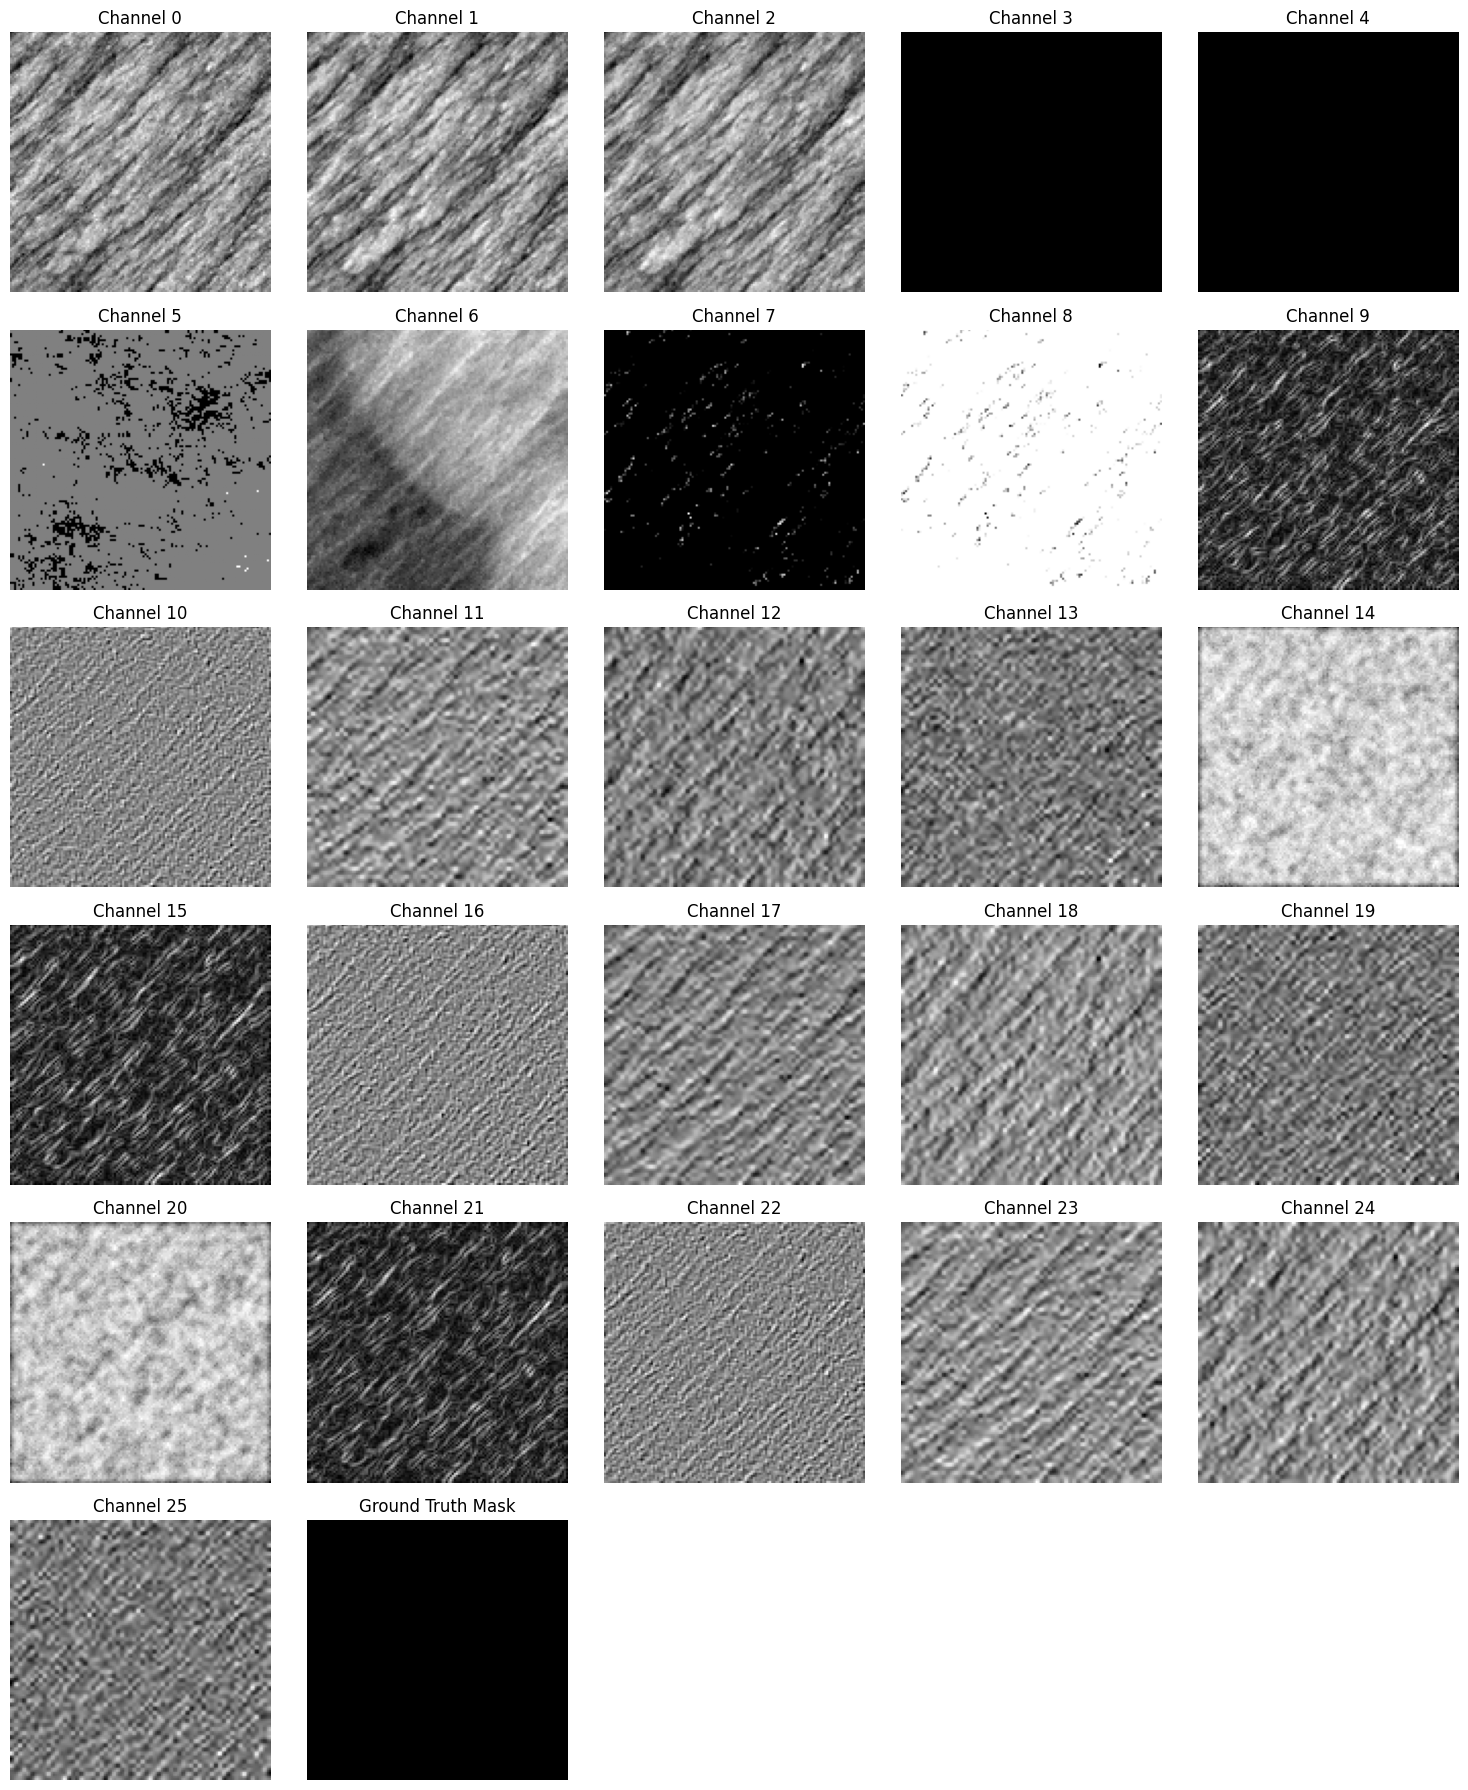

In [25]:
idx = 0  # Index within the batch
num_channels = x_batch.shape[-1]
cols = 5
rows = (num_channels + 1 + cols - 1) // cols  # +1 for the mask

plt.figure(figsize=(3 * cols, 3 * rows))

# Plot each feature channel
for i in range(num_channels):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_batch[idx, :, :, i], cmap='gray')
    plt.title(f"Channel {i}")
    plt.axis("off")

# Plot ground truth mask
plt.subplot(rows, cols, num_channels + 1)
plt.imshow(y_batch[idx].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Modeling

In [46]:
# Step 1: Input for 26-band data
input_26 = tf.keras.layers.Input(shape=(128, 128, 26), name='input_26')

# Step 2: Project 26 → 3 channels
reduced = tf.keras.layers.Conv2D(
    filters=3,
    kernel_size=(1, 1),
    padding='same',
    use_bias=False,
    kernel_initializer='he_normal',
    name='reduce_to_rgb'
)(input_26)

# Step 3: Pass to Unet model (with input_shape=(128,128,3))
base_model = sm.Unet(
    backbone_name='resnet50',
    input_shape=(128, 128, 3),
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)

# Step 4: Get the output from the Unet
output = base_model(reduced)

# Step 5: Build full model from 26-band input to final output
model = tf.keras.Model(inputs=input_26, outputs=output)


In [47]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_26 (InputLayer)           │ (None, 128, 128, 26)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reduce_to_rgb (Conv2D)          │ (None, 128, 128, 3)    │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 128, 128, 1)    │    32,561,114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,561,192 (124.21 MB)

 Trainable params: 32,513,634 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

Dice Loss is a loss function commonly used for image segmentation tasks. It's based on the Dice Similarity Coefficient (DSC), which measures how similar two sets are — often used to compare a predicted segmentation mask and a ground truth mask.

Dice Loss is especially useful when:

You have imbalanced data: e.g., very few pixels belong to the positive class (like tumors, water, clouds).

In [48]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)

def binary_iou(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [49]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        binary_iou
    ]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedul = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

checkpoint = ModelCheckpoint(
    save_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

In [50]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, lr_schedul, checkpoint]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3259 - binary_iou: 0.2388 - loss: 0.9285 - precision_3: 0.2473 - recall_3: 0.8820
Epoch 1: val_loss improved from inf to 0.82272, saving model to /content/drive/MyDrive/food_seg_model/unet.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.3277 - binary_iou: 0.2400 - loss: 0.9247 - precision_3: 0.2485 - recall_3: 0.8819 - val_accuracy: 0.3779 - val_binary_iou: 0.3246 - val_loss: 0.8227 - val_precision_3: 0.3290 - val_recall_3: 0.9768 - learning_rate: 1.0000e-04
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6105 - binary_iou: 0.3427 - loss: 0.6623 - precision_3: 0.3679 - recall_3: 0.8302
Epoch 2: val_loss improved from 0.82272 to 0.70788, saving model to /content/drive/MyDrive/food_seg_model/unet.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 162s 6s/step - accuracy: 0.6124 - binary_iou: 0.3442 - loss: 0.6615 - precision_3: 0.3701 - recall_3: 0.8282 - val_accuracy: 0.4975 - val_binary_iou: 0.3216 - val_loss: 0.

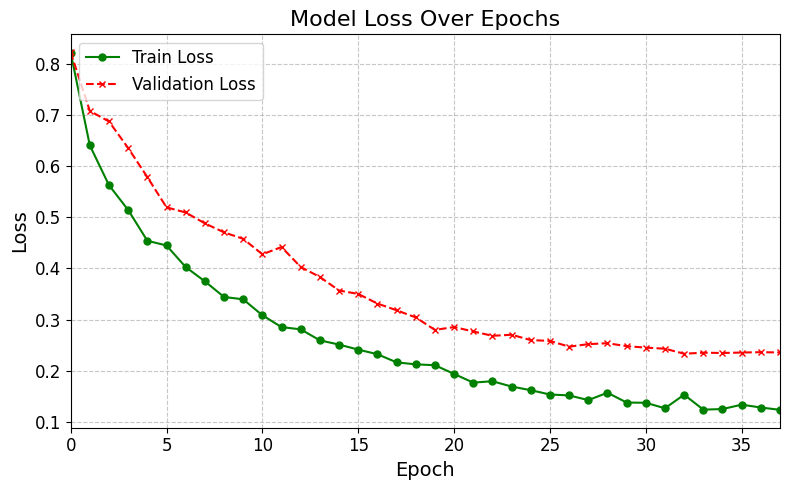

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


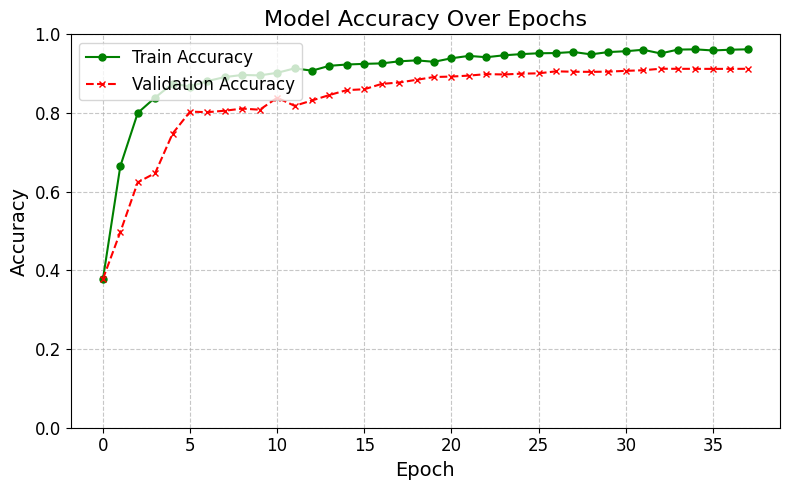

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


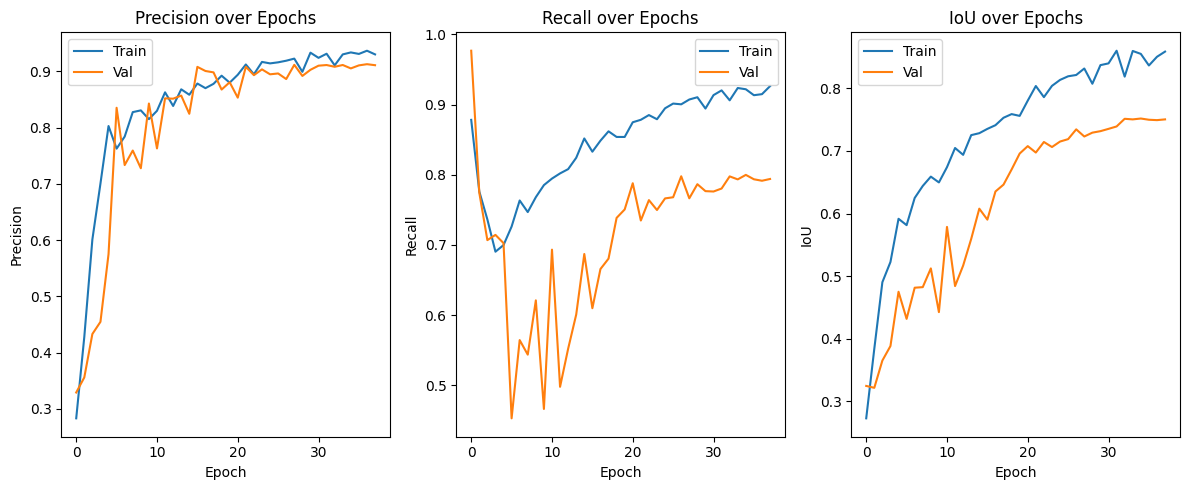

In [54]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history["precision_3"], label="Train")
plt.plot(history.history["val_precision_3"], label="Val")
plt.title("Precision over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history["recall_3"], label="Train")
plt.plot(history.history["val_recall_3"], label="Val")
plt.title("Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history["binary_iou"], label="Train")
plt.plot(history.history["val_binary_iou"], label="Val")
plt.title("IoU over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()

plt.tight_layout()
plt.show()

# Load Model

In [55]:
# Load the model
loaded_model = load_model(
    save_path,
    custom_objects={'binary_iou': binary_iou}
)
# Verify the model is loaded correctly (optional)
loaded_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_26 (InputLayer)           │ (None, 128, 128, 26)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reduce_to_rgb (Conv2D)          │ (None, 128, 128, 3)    │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 128, 128, 1)    │    32,561,114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,588,462 (372.27 MB)

 Trainable params: 32,513,634 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

 Optimizer params: 65,027,270 (248.06 MB)

# Model Evaluation

In [56]:
loss, accuracy, recall, precision, iou = loaded_model.evaluate(test_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"IoU: {iou}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9452 - binary_iou: 0.7193 - loss: 0.1623 - precision_3: 0.8931 - recall_3: 0.8137
Loss: 0.17693445086479187
Accuracy: 0.9389316439628601
Recall: 0.783972442150116
Precision: 0.8712647557258606
IoU: 0.6742870211601257


In [57]:
predictions=loaded_model.predict(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [58]:
img[0].shape

(128, 128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


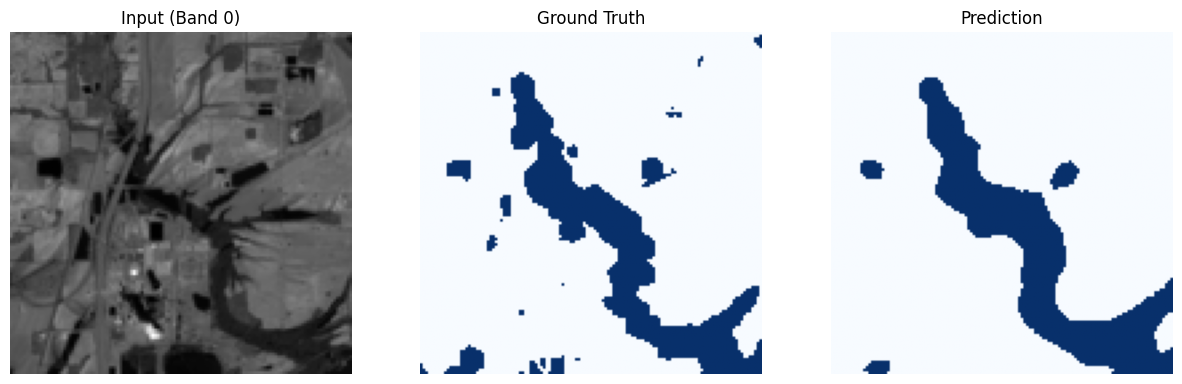

In [59]:
X_batch, y_batch = test_generator[2]

# Predict
preds = loaded_model.predict(X_batch)

# Threshold
preds_thresholded = (preds > 0.5).astype(np.uint8)

# Visualize first image in batch
i = 0
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(X_batch[i][..., 0], cmap='gray')
plt.title('Input (Band 0)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(y_batch[i].squeeze(), cmap='Blues')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(preds_thresholded[i].squeeze(), cmap='Blues')
plt.title('Prediction')
plt.axis('off')

plt.show()


In [60]:
y_true_all = []
y_pred_all = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    preds_batch = loaded_model.predict(X_batch)

    # Flatten and threshold predictions and masks
    y_true_all.extend(y_batch.flatten())
    y_pred_all.extend((preds_batch.flatten() > 0.5).astype(np.uint8))

y_true_all = np.array(y_true_all, dtype=np.uint8)
y_pred_all = np.array(y_pred_all, dtype=np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [61]:
report = classification_report(y_true_all, y_pred_all, target_names=["Background", "Object"])
print(report)

              precision    recall  f1-score   support

  Background       0.95      0.97      0.96    614978
      Object       0.87      0.78      0.83    138686

    accuracy                           0.94    753664
   macro avg       0.91      0.88      0.89    753664
weighted avg       0.94      0.94      0.94    753664



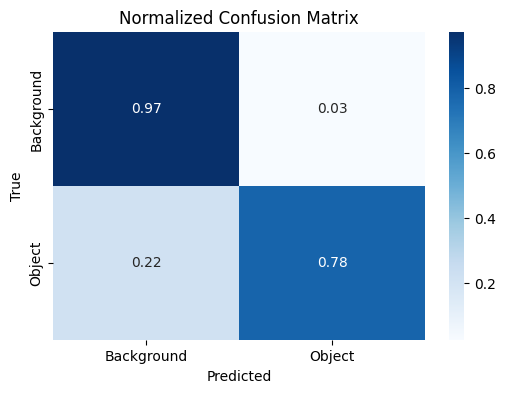

In [62]:
# Get confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Optional normalization
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, cmap="Blues", xticklabels=["Background", "Object"], yticklabels=["Background", "Object"], fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()
